### Neural style transfer in PyTorch

This tutorial implements the "slow" neural style transfer based on the VGG19 model.

It closely follows the official neural style tutorial you can find [here](http://pytorch.org/tutorials/advanced/neural_style_tutorial.html).

__Note:__ if you didn't sit through the explanation of neural style transfer in the on-campus lecture, you're _strongly recommended_ to follow the link above instead of this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pyplot import imread
from skimage.transform import resize, rotate

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# desired size of the output image
imsize = 512   # REDUCE THIS TO 128 IF THE OPTIMIZATION IS TOO SLOW FOR YOU
def image_loader(image_name):
    image = resize(imread(image_name), [imsize, imsize])
    image = image.transpose([2,0,1]) / image.max()
    image = Variable(dtype(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

use_cuda = torch.cuda.is_available()

print("torch", torch.__version__)
if use_cuda:
    print("Using GPU.")
else:
    print("Not using GPU.")
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor



torch 1.10.0+cu111
Using GPU.


### Draw input images

In [2]:
!mkdir -p images
!wget https://github.com/yandexdataschool/Practical_DL/raw/fall21/week10_interpretability/bonus_style_transfer/images/wave.jpg -O images/wave.jpg
style_img = image_loader("images/wave.jpg").type(dtype)

!wget http://cdn.cnn.com/cnnnext/dam/assets/170809210024-trump-nk.jpg -O images/my_img.jpg
content_img = image_loader("images/my_img.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

--2021-11-26 17:42:59--  https://github.com/yandexdataschool/Practical_DL/raw/fall21/week10_interpretability/bonus_style_transfer/images/wave.jpg
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall21/week10_interpretability/bonus_style_transfer/images/wave.jpg [following]
--2021-11-26 17:43:00--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall21/week10_interpretability/bonus_style_transfer/images/wave.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123262 (120K) [image/jpeg]
Saving to: ‘images/wave.jpg’

images/wave.jpg     100%[===========

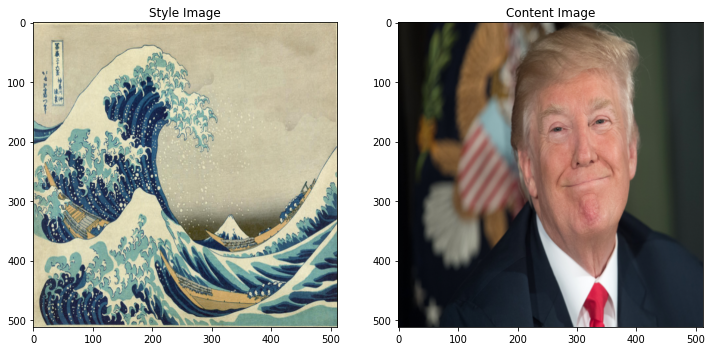

In [3]:
def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = image.numpy().transpose([1,2,0])
    plt.imshow(image / np.max(image))
    if title is not None:
        plt.title(title)

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
imshow(style_img.data, title='Style Image')
plt.subplot(1,2,2)
imshow(content_img.data, title='Content Image')

### Define Style Transfer Losses

As shown in the lecture, we define two loss functions: content and style losses.

Content loss is simply a pointwise mean squared error of high-level features while style loss is the error between gram matrices of intermediate feature layers.

To obtain the feature representations we use a pre-trained VGG19 network.

In [4]:
import torchvision.models as models

cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        self.weight = weight

    def forward(self, input):
        self.loss = F.mse_loss(input * self.weight, self.target)
        return input.clone()

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [6]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
    
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight

    def forward(self, input):
        self.G = gram_matrix(input)
        self.G.mul_(self.weight)
        self.loss = F.mse_loss(self.G, self.target)
        return input.clone()

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

### Style transfer pipeline

We can now define a unified "model" that computes all the losses on the image triplet (content image, style image, optimized image) so that we could optimize them with backprop (over image pixels).

In [7]:
content_weight=1            # coefficient for content loss
style_weight=1000           # coefficient for style loss
content_layers=('conv_4',)  # use these layers for content loss
style_layers=('conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5') # use these layers for style loss


In [8]:
content_losses = []
style_losses = []

model = nn.Sequential()  # the new Sequential module network
# move these modules to the GPU if possible:
if use_cuda:
    model = model.cuda()

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).clone()
            target_feature_gram = gram_matrix(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).clone()
            target_feature_gram = gram_matrix(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***

### Optimization

We can now optimize both style and content loss over input image.

In [16]:
input_image = Variable(content_img.clone().data, requires_grad=True)
optimizer = torch.optim.Adam([input_image], lr=0.1)

In [18]:
num_steps = 300

for i in range(num_steps):
    # correct the values of updated input image
    input_image.data.clamp_(0, 1)

    model(input_image)
    style_score = 0
    content_score = 0
    for sl in style_losses:
        style_score += sl.backward()
    for cl in content_losses:
        content_score += cl.backward()
        
    if i % 10 == 0:  # <--- adjust the value to see updates more frequently
        
        print('Step # {} Style Loss : {:4f} Content Loss: {:4f}'.format(
            i, style_score.data.item(), content_score.item()))
        plt.figure(figsize=[10,10])
        imshow(input_image.data)
        plt.show()
        
    loss = style_score + content_score
    
    optimizer.step(lambda: loss)
    optimizer.zero_grad()
    
# a last correction...
input_image.data.clamp_(0, 1)

### Final image

In [ ]:
plt.figure(figsize=[10,10])
imshow(input_image.data)
plt.show()